In [987]:
from openseespy.opensees import *
import matplotlib.pyplot as plt
import numpy as np
import opsvis as opsv
%matplotlib widget

In [988]:
wipe() 
model('basic', '-ndm', 2, '-ndf', 3)

In [989]:
# CREATE NODES
B = 8000
H = 3600
node(1, 0, 0)           # Bottom left fixed
node(2, 0, 500)         # Node 2 
node(3, 0, H + 500)     # Top left
node(4, B, 0)           # Bottom right fixed
node(5, B, 500)         # Node 5
node(6, B, H + 500)     # Top right

node(7, 0, 500)         # for left BRB connections at bottom
node(8, B/2, 500)       # for mid steel bracket 
node(9, B, 500)         # for right BRB connections at bottom

node(10, B/2, H+500)    # BRB node
node(11, B/2, H+500)    # Apex BRB connections

node(12, B/2, 0)        # Bottom mid-base node

In [990]:
fix(1, 1, 1, 1)
fix(4, 1, 1, 1)
fix(12, 1, 1, 1)

<Axes: >

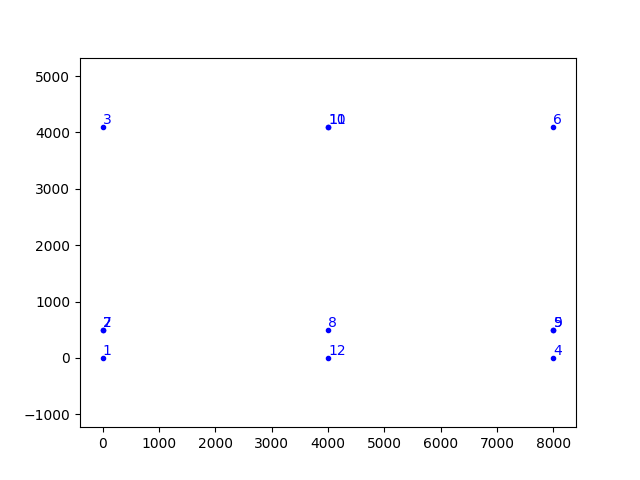

In [991]:
opsv.plot_model()

In [992]:
# CREATE MATERIALS

brbSteelCoreMatTag = 1
brbSpringMatTag = 2

## GLULAM => property directly given in ElasticBeamColumn element

## BRB COMPONENTS
# Steel core
# uniaxialMaterial('Steel4', matTag, Fy, E0, '-kin', b_k, *params, b_kc, R_0c, r_1c, r_2c, '-iso', b_i, rho_i, b_l, R_i, l_yp, b_ic, rho_ic, b_lc, R_ic, '-ult', f_u, R_u, f_uc, R_uc)
uniaxialMaterial('Steel4', brbSteelCoreMatTag, 
    294.0,                                  # fy
    256200.0,                               # Eeq
    '-kin', 0.004,                          # bk_tension
    25.0, 0.91, 0.15,                       # R0, r1, r2 (tension)
    0.025, 25.0, 0.91, 0.15,                # bk_compression, R0c, r1c, r2c
    '-iso', 0.0008, 1.39, 0.0007, 3.0, 1.0, # bi, rho_it, bl, Ri, lyp
            0.0008, 1.03, 0.0007, 3.0,      # bi_c, rho_ic, bl_c, Ri_c
    '-ult', 485.0, 2.0, 735.0, 2.0          # fu_t, Ru_t, fu_c, Ru_c
)
# For elastoplastic spring to model additional restraints
# uniaxialMaterial('Steel01', matTag, Fy, E0, b, a1, a2, a3, a4)
uniaxialMaterial('Steel01', brbSpringMatTag,          
                 27000*4.6,                 # Fy = E0 * yield_displacement
                 27000,                     # E0
                 0.10)                      # post-yield hardening ratio

In [993]:
# Beam
h_beam = 585.0
b_beam = 315.0
A_beam = h_beam * b_beam
Iz_beam = b_beam * (h_beam)**3 / 12
E = 10000.0e6 # MPa
beam_nodes = [[7,8], [8,9], [3,11], [11,6]]

geomTransf('Linear', 1)
# element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, Iz, transfTag)
for i, each in enumerate(beam_nodes):
    element('elasticBeamColumn', i+1, *each, A_beam, E, Iz_beam, 1)

In [994]:
# Column
# element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, Iz, transfTag)

d1_col = 315.0
d2_col = 315.0
A_col = d1_col * d2_col
Iz_col = d1_col * (d2_col)**3 / 12
col_nodes = [[1,2], [2,3], [4,5], [5,6]]

geomTransf('Linear', 2)
for i, each in enumerate(col_nodes):
    element('elasticBeamColumn', len(beam_nodes)+i+1, *each, A_col, E, Iz_col, 2)

In [995]:
# BRB
# element('Truss', eleTag, *eleNodes, A, matTag)
# element('twoNodeLink', eleTag, *eleNodes, '-mat', *matTags, '-dir', *dir)

currentEleNums = len(beam_nodes) + len(col_nodes)
element('Truss', currentEleNums + 1, *[7, 10], 1120, brbSteelCoreMatTag)
element('twoNodeLink', currentEleNums + 2, *[7,10], '-mat', brbSpringMatTag, '-dir', 1)
element('Truss', currentEleNums + 3, *[9, 10], 1120, brbSteelCoreMatTag)
element('twoNodeLink', currentEleNums + 4, *[9,10], '-mat', brbSpringMatTag, '-dir', 1)

<Axes: >

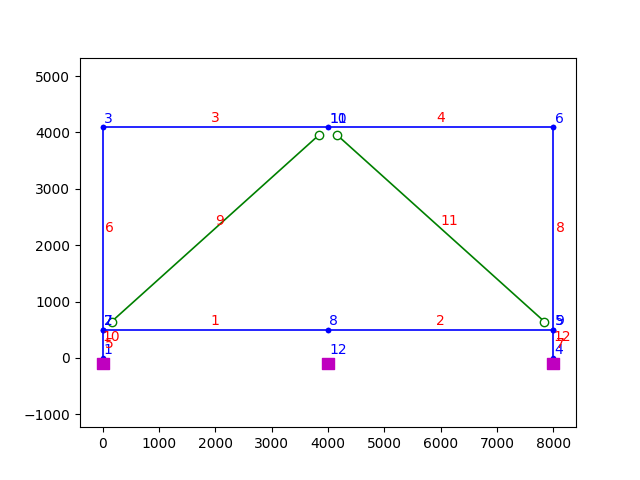

In [996]:
opsv.plot_model()

In [997]:
# Dowelled connection - Pinching4 to model cyclic hysteresis for connection
topDowelMatTag_1 = 3
topDowelMatTag_2 = 4

uniaxialMaterial('Pinching4', topDowelMatTag_1,
    # Envelope points (positive)
    12028., 0.01,
    421008., 0.7, 
    774948., 2.0, 
    962000., 3.4, 
    # Envelope points (negative)
    -12028., -0.01, 
    -421008., -0.7,
    -774948., -2.0,
    -962000., -3.4,
    # Reloading rules
    0.0, 0.0, -0.05,            # rDispP, rForceP, uForceP
    0.0, 0.0, -0.05,            # rDispN, rForceN, uForceN
    # Degradation (none)
    0.0, 0.0, 0.0, 0.0, 0.0,    # gK
    0.0, 0.0, 0.0, 0.0, 0.0,    # gD
    0.0, 0.0, 0.0, 0.0, 0.0,    # gF
    0.0,                        # gE
   'energy'                   # dmgType
)

# ElasticMultiLinear - simulates initial slip in dowelled connection
uniaxialMaterial("ElasticMultiLinear", topDowelMatTag_2,
    "-strain", *[-2.0, -0.5, 0.0, 0.5, 2.0],
    "-stress", *[-2.5e7, -8000, 0.0, 8000, 2.5e7]
)

# zeroLength elements (must avoid overlapping direction assignments)
# Use Pinching4 for dir 1 (X), and ElasticMultiLinear for dir 2 (Y)
# element('zeroLength', 13, *[10, 11], '-mat', topDowelMatTag_1, topDowelMatTag_1, '-dir', 1, 2)
element('zeroLength', 13, *[10, 11], '-mat', topDowelMatTag_1, '-dir', 1)
element('zeroLength', 14, *[10, 11], '-mat', topDowelMatTag_2, '-dir', 2)


In [998]:
# Bottom dowelled connection - Pinching4 (half-strength)
bottomDownMatTag = 5
uniaxialMaterial('Pinching4', bottomDownMatTag,
    # Positive envelope
    6014., 0.01,
    210504., 0.7,
    387474., 2.0,
    481000., 3.4,
    # Negative envelope (symmetric)
    -6014., -0.01,
    -210504., -0.7,
    -387474., -2.0,
    -481000., -3.4,
    # Reloading rules
    0.0, 0.0, -0.05,
    0.0, 0.0, -0.05,
    # Degradation (none)
    0.0, 0.0, 0.0, 0.0, 0.0,  # gK
    0.0, 0.0, 0.0, 0.0, 0.0,  # gD
    0.0, 0.0, 0.0, 0.0, 0.0,  # gF
    0.0,
    "energy"
)

# element('zeroLength', 15, *[2,7], '-mat', bottomDownMatTag, bottomDownMatTag, '-dir', 1, 2)
element('zeroLength', 15, *[2,7], '-mat', bottomDownMatTag, '-dir', 1)
# element('zeroLength', 16, *[5,9], '-mat', bottomDownMatTag, bottomDownMatTag, '-dir', 1, 2)
element('zeroLength', 16, *[5,9], '-mat', bottomDownMatTag, '-dir', 1)
# element('twoNodeLink', 17, *[8,12], '-mat', bottomDownMatTag, bottomDownMatTag, '-dir', 1, 2)
element('twoNodeLink', 17, *[8,12], '-mat', bottomDownMatTag, '-dir', 1)
element('twoNodeLink', 18, *[8,12], '-mat', bottomDownMatTag, '-dir', 2)

<Axes: >

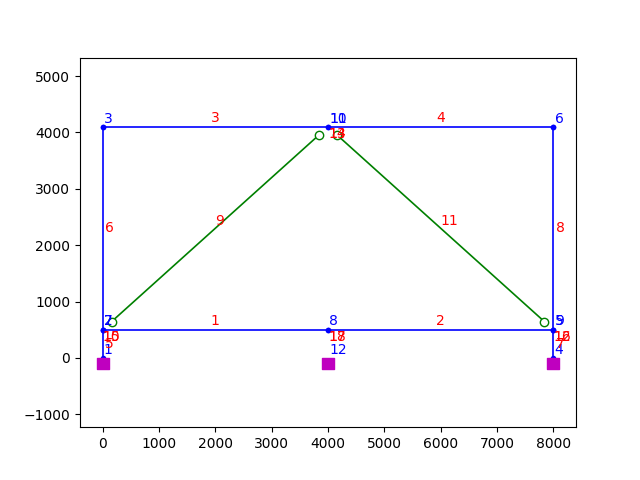

In [999]:
opsv.plot_model()

In [1000]:
# APPLY LOADS
timeSeries('Linear', 1)
pattern('Plain', 1, 1)
load(3, 10e3, 0, 0)

In [1001]:
# SETUP ANALYSIS
constraints("Transformation")
numberer("Plain")
system("BandGeneral")
integrator("LoadControl", 0.01)
test("NormUnbalance", 1.0e-6, 1000, 4)
algorithm("Newton")
analysis("Static")

In [1002]:
# ANALYZE
analyze(100)

WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 23
WARNING NewtonRaphson::solveCurrentStep() -the LinearSysOfEqn failed in solve()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.01
OpenSees > analyze failed, returned: -3 error flag


-3

In [1003]:
# POST-PROCESSSING ANALYSIS RESULTS

disp = nodeDisp(3, 1)
print(f"The displacement of node 3 is {disp} mm.")

The displacement of node 3 is 0.0 mm.


inf

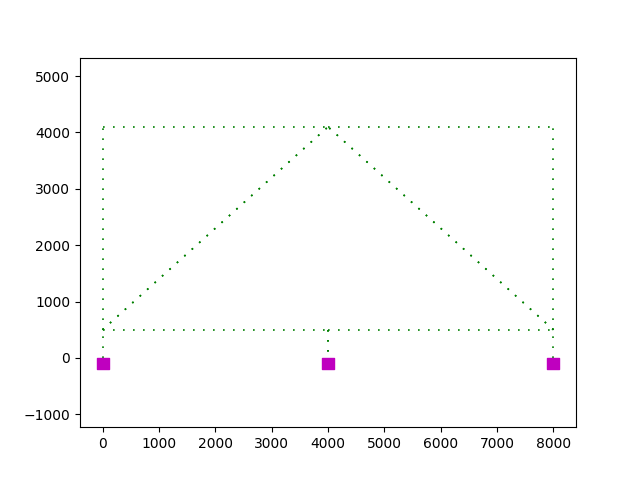

In [1004]:
opsv.plot_defo()